In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

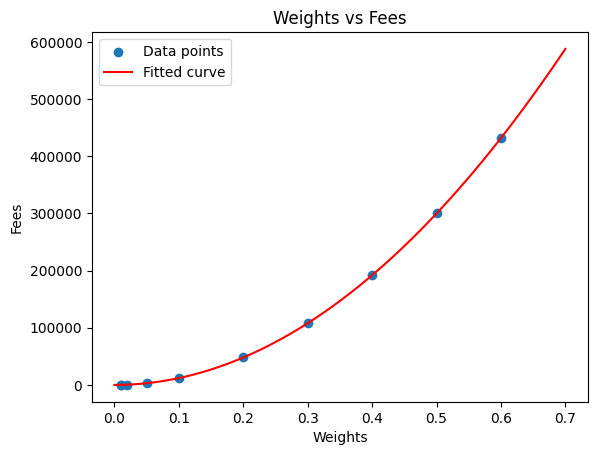

Model coefficients: [ 1.20000000e+06 -5.34758642e-10  6.35642577e-12]


In [3]:
weights = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.05, 0.01, 0.02])
fees = np.array([120, 12000, 48000, 108000, 192000, 300000, 432000, 3000, 120, 480])

model = np.polyfit(weights, fees, 2)

# plot
plt.scatter(weights, fees, label="Data points")
x = np.linspace(0, 0.7, 100)
plt.plot(x, np.polyval(model, x), color="red", label="Fitted curve")
plt.legend()
plt.xlabel("Weights")
plt.ylabel("Fees")
plt.title("Weights vs Fees")
plt.show()
print(f"Model coefficients: {model}")


In [4]:
10000 * 0.1 - 1.2 * 10000 * 0.01

880.0

$$ \sum_{p} (\pi_p r_p - 1.2\pi_p^2)$$
$$ \sum_{p} |\pi_p| \leq 1  $$

In [5]:
def maximize_portfolio_objective(expected_returns):
    """
    Maximizes the objective function sum(pi_p * r_p - 1.2 * pi_p^2)
    subject to the constraint sum(|pi_p|) <= 1.

    Args:
        expected_returns: A list or NumPy array of expected returns (r_p)
                          for each asset p.

    Returns:
        A NumPy array containing the optimal portfolio weights (pi_p),
        or None if optimization fails.
    """
    n_assets = len(expected_returns)
    r = np.array(expected_returns)

    # Objective function to minimize (negative of the original objective)
    def objective(pi):
        return -np.sum(pi * r - 1.2 * pi**2)

    # Gradient of the objective function (optional but improves performance)
    def jacobian(pi):
        return -(r - 2.4 * pi)

    # Constraint: sum(|pi|) <= 1  which is equivalent to 1 - sum(|pi|) >= 0
    constraints = {"type": "ineq", "fun": lambda pi: 1.0 - np.sum(np.abs(pi))}

    # Initial guess for the weights (e.g., zeros or small equal weights)
    # Using zeros as initial guess
    initial_guess = np.zeros(n_assets)

    # Bounds for weights (optional, but weights usually aren't infinitely large)
    # We can set bounds between -1 and 1 since sum(|pi|) <= 1
    bounds = [(-1.0, 1.0) for _ in range(n_assets)]

    # Perform the optimization
    result = minimize(
        objective,
        initial_guess,
        method="SLSQP",
        jac=jacobian,  # Provide the gradient
        constraints=constraints,
        bounds=bounds,
        options={"disp": False},  # Set to True to see optimization details
    )

    if result.success:
        # Return the optimal weights, potentially rounding small values
        optimal_weights = result.x
        # Optional: Set very small weights (close to zero) to exactly zero
        optimal_weights[np.isclose(optimal_weights, 0)] = 0.0
        return optimal_weights
    else:
        print(f"Optimization failed: {result.message}")
        return None


# --- Example Usage ---
# Define expected returns for, say, 3 assets
previous_returns = {
    "Refrigerators": 0.020713448079427082,
    "Earrings": 0.12367402886284722,
    "Blankets": -0.32888405330882353,
    "Sleds": -0.2829537109375,
    "Sculptures": 0.19637428385416666,
    "PS6": 0.3095545703125,
    "Serum": -0.8157531666666666,
    "Lamps": 6.103515625e-05,
    "Chocolate": -0.000404595947265625,
}

expected_returns_dict = {
    "Cactus": previous_returns["Blankets"],
    "Coffee": previous_returns["Serum"],
    "Sauce": previous_returns["Earrings"],
    "Solar": previous_returns["Sleds"],
    "Moonshine": previous_returns["Lamps"],
    "Haystacks": previous_returns["Refrigerators"],
    "Red Flag": previous_returns["Sculptures"],
    "Shirts": previous_returns["Chocolate"],
    "VR": previous_returns["PS6"],
}

# Extract the expected returns values in the order of the dictionary keys
expected_returns_example = list(expected_returns_dict.values())
asset_names = list(expected_returns_dict.keys())


# Calculate the optimal weights
optimal_weights = maximize_portfolio_objective(expected_returns_example)

if optimal_weights is not None:
    print("Optimal Portfolio Weights:")
    for name, w in zip(asset_names, optimal_weights):
        print(f"  {name}: {round(w * 100)}%")  # Multiply by 100 and add % sign

    # Verify the constraint
    print(
        f"\nSum of absolute weights: {np.sum(np.abs(optimal_weights)):.4f} (should be <= 1)"
    )

    # Calculate the maximized objective value (using the original function)
    r = np.array(expected_returns_example)
    max_obj_value = np.sum(optimal_weights * r - 1.2 * optimal_weights**2)
    print(f"Maximized Objective Function Value: {max_obj_value:.4f}")
    print(f"Profits {max_obj_value * 1_000_000:.0f}")

Optimal Portfolio Weights:
  Cactus: -14%
  Coffee: -34%
  Sauce: 5%
  Solar: -12%
  Moonshine: 0%
  Haystacks: 1%
  Red Flag: 8%
  Shirts: 0%
  VR: 13%

Sum of absolute weights: 0.8660 (should be <= 1)
Maximized Objective Function Value: 0.2091
Profits 209123


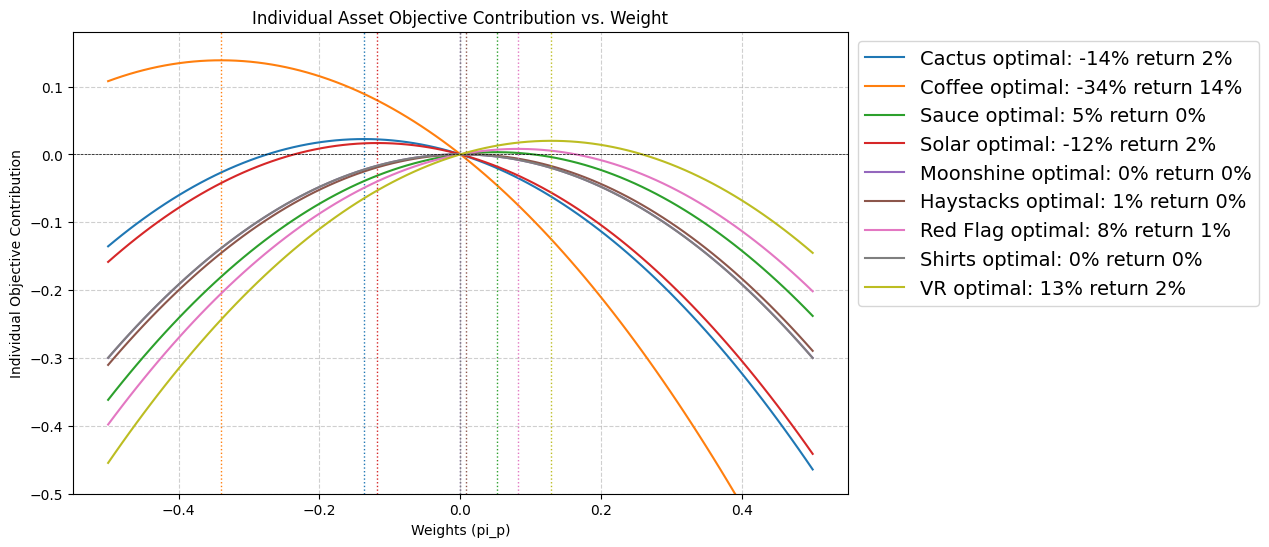

In [6]:
x = np.linspace(-0.5, 0.5, 100)
# plot set figure size
plt.figure(figsize=(10, 6))

for name, return_value in expected_returns_dict.items():
    y = return_value * x - 1.2 * x**2
    # Calculate the x-coordinate where the maximum occurs
    x_max = return_value / (2 * 1.2)
    # Plot the function and get the line object to extract the color
    line = plt.plot(
        x,
        y,
        label=f"{name} optimal: {round(x_max * 100)}% return {round(100 * (return_value * x_max - 1.2 * x_max**2))}%",
    )

    line_color = line[0].get_color()

    # Plot a vertical line at the maximum x-coordinate with the same color
    plt.axvline(x=x_max, color=line_color, linestyle=":", lw=1)


plt.axhline(0, color="black", lw=0.5, ls="--")
# legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel("Weights (pi_p)")
plt.ylabel("Individual Objective Contribution")
plt.title("Individual Asset Objective Contribution vs. Weight")
plt.ylim(bottom=-0.5)  # Adjust ylim if needed to see all lines clearly
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


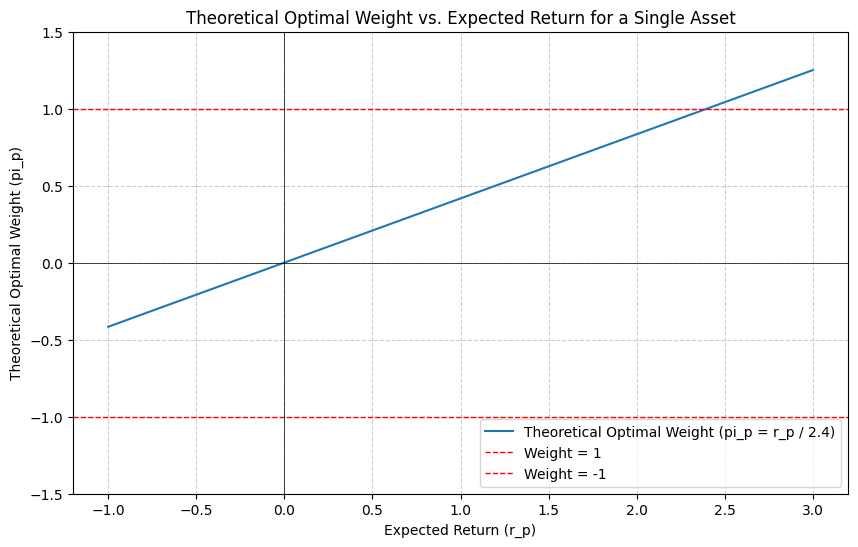

Slope of the line: 0.42


In [7]:
# Define a range of hypothetical expected returns
returns_range = np.linspace(-1.0, 3.0, 200)

# Calculate the theoretical optimal weight for each return using pi_p = r_p / 2.4
theoretical_optimal_weights = returns_range / 2.4

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(
    returns_range,
    theoretical_optimal_weights,
    label="Theoretical Optimal Weight (pi_p = r_p / 2.4)",
)

# Add lines indicating the bounds implied by the constraint |pi_p| <= 1
plt.axhline(1.0, color="red", linestyle="--", lw=1, label="Weight = 1")
plt.axhline(-1.0, color="red", linestyle="--", lw=1, label="Weight = -1")

# Add lines for zero axes
plt.axhline(0.0, color="black", linestyle="-", lw=0.5)
plt.axvline(0.0, color="black", linestyle="-", lw=0.5)

# Add labels and title
plt.xlabel("Expected Return (r_p)")
plt.ylabel("Theoretical Optimal Weight (pi_p)")
plt.title("Theoretical Optimal Weight vs. Expected Return for a Single Asset")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(-1.5, 1.5)  # Adjust ylim to show bounds clearly
plt.show()

# include slope of line
print(f"Slope of the line: {1/2.4:.2f}")


In [8]:
# comparison of optimal vs suboptimal coffee returns
optimal = expected_returns_dict["Coffee"] * optimal_weights[0] * 1e6
suboptimal = expected_returns_dict["Coffee"] * -0.14 * 1e6
print(f"Optimal Coffee Returns: {optimal:.0f}")
print(f"Suboptimal Coffee Returns: {suboptimal:.0f}")
print(f"Difference: {optimal - suboptimal:.0f} Percent: {100 * (optimal - suboptimal) / optimal:.2f}%")

Optimal Coffee Returns: 111787
Suboptimal Coffee Returns: 114205
Difference: -2419 Percent: -2.16%


In [9]:
# reverse equation to solve for returns needed for 100 percent weight
# The optimal weight pi_p for an asset p is given by pi_p = r_p / (2 * 1.2)
# We want to find r_p when pi_p = 1 (100% weight)
# r_p = pi_p * 2 * 1.2
required_return_for_100_percent = 1.0 * 2 * 1.2
print(f"Required return for 100% weight: {required_return_for_100_percent}")


Required return for 100% weight: 2.4
